<a href="https://colab.research.google.com/github/caiogoia123/projeto_final_marvel/blob/develop/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import requests
import hashlib
import time
import datetime
from google.colab import userdata
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
public_key=userdata.get('public_key_marvel')
private_key=userdata.get('private_key_marvel')
timestamp = str(time.time())
md5_hash= timestamp + private_key + public_key
md5_hash = hashlib.md5(md5_hash.encode("utf-8")).hexdigest()

DB_NAME = 'marvel_characters_teste.db'

# Requisição manual para testes

In [ ]:
# Modifique a URL para o endpoint de personagens
url = f"https://gateway.marvel.com/v1/public/series?ts={timestamp}&apikey={public_key}&hash={md5_hash}"
print(url)
# Código de tratamento dos dados
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print(f"Total de personagens: {data['data']['total']}")
    for char in data['data']['results']:
        print(char)

# Criação banco de dados

In [ ]:
# conn = sqlite3.connect('marvel_characters_teste.db')
# cursor = conn.cursor()

# # Executar consulta com parâmetro
# cursor.execute('''
#     DROP TABLE IF EXISTS series_events;
# ''')

In [ ]:
 # Função para criar o banco
def create_database():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Tabela Personagens
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela Comics
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS comics (
        id INTEGER PRIMARY KEY,
        digital_id INTENGER,
        title TEXT NOT NULL,
        issue_number INTEGER,
        description TEXT,
        variant_description TEXT,
        modified TEXT,
        format TEXT,
        page_count INTEGER,
        series_URI TEXT,
        series_name TEXT,
        price REAL,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS series (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        start_year INTEGER,
        end_year INTEGER,
        rating TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        start TEXT,
        end TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela de relacionamento characters e events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_events (
        id_character INTEGER,
        id_event INTEGER,
        PRIMARY KEY(id_character, id_event),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_event) REFERENCES events(id)
    )''')

    # Tabela de relacionamento characters e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_series (
        id_character INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_character, id_serie),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    # Tabela de relacionamento events e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events_series (
        id_event INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_event, id_serie),
        FOREIGN KEY(id_event) REFERENCES events(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    conn.commit()
    conn.close()

In [ ]:
create_database()

# Extração de dados

In [ ]:
MAX_RETRIES = 3  # Tentativas por requisição
DELAY = 1  # Atraso entre requisições em segundos

In [ ]:
 # Função para pegar todos os personagens
def get_all_characters():
     conn = sqlite3.connect(DB_NAME)
     cursor = conn.cursor()

     offset = 0
     total = None
     inserted = 0

     while True:
         for attempt in range(MAX_RETRIES):
             try:
                 # Autenticação
                 ts = str(time.time())
                 hash_input = ts + private_key + public_key
                 md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                 params = {
                     'ts': ts,
                     'apikey': public_key,
                     'hash': md5_hash,
                     'limit': 100,
                     'offset': offset
                 }

                 response = requests.get(
                     'https://gateway.marvel.com/v1/public/characters',
                     params=params,
                     timeout=10
                 )
                 response.raise_for_status()

                 data = response.json()
                 total = data['data']['total'] if total is None else total
                 results = data['data']['results']

                 # Inserir no banco
                 for char in results:
                     cursor.execute('''
                         INSERT OR REPLACE INTO characters
                         VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                     ''', (
                         char['id'],
                         char['name'],
                         char.get('description', ''),
                         char['modified'],
                         char['comics']['available'],
                         char['comics']['collectionURI'],
                         char['events']['available'],
                         char['events']['collectionURI'],
                         char['stories']['available'],
                         char['stories']['collectionURI'],
                         char['series']['available'],
                         char['series']['collectionURI'],
                     ))

                 conn.commit()
                 inserted += len(results)
                 print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                 # Verificar se terminou
                 if offset + len(results) >= total:
                     print("\nTodos os personagens foram armazenados!")
                     return

                 offset += 100
                 time.sleep(DELAY)
                 break  # Sai do loop de tentativas

             except requests.exceptions.RequestException as e:
                 print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                 time.sleep(2 ** attempt)  # Backoff exponencial
                 continue
         else:
             print("Falha após múltiplas tentativas. Abortando...")
             break

     conn.close()

In [ ]:
def get_all_events():
     conn = sqlite3.connect(DB_NAME)
     cursor = conn.cursor()

     offset = 0
     total = None
     inserted = 0

     while True:
         for attempt in range(MAX_RETRIES):
             try:
                 # Autenticação
                 ts = str(time.time())
                 hash_input = ts + private_key + public_key
                 md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                 params = {
                     'ts': ts,
                     'apikey': public_key,
                     'hash': md5_hash,
                     'limit': 10,
                     'offset': offset
                 }
                 response = requests.get(
                     'https://gateway.marvel.com/v1/public/events',
                     params=params,
                     timeout=10
                 )
                 response.raise_for_status()
                 data = response.json()
                 total = data['data']['total'] if total is None else total
                 results = data['data']['results']

                 # Inserir no banco
                 for char in results:
                     cursor.execute('''
                         INSERT OR REPLACE INTO events
                         VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                     ''', (
                         char['id'],
                         char['title'],
                         char.get('description', ''),
                         char['modified'],
                         char['start'],
                         char['end'],
                         char['comics']['available'],
                         char['comics']['collectionURI'],
                         char['characters']['available'],
                         char['characters']['collectionURI'],
                         char['stories']['available'],
                         char['stories']['collectionURI'],
                         char['creators']['available'],
                         char['creators']['collectionURI'],
                         char['series']['available'],
                         char['series']['collectionURI']
                     ))

                 conn.commit()
                 inserted += len(results)
                 print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                 # Verificar se terminou
                 if offset + len(results) >= total:
                     print("\nTodos os eventos foram armazenados!")
                     return

                 offset += 10
                 time.sleep(DELAY)
                 break  # Sai do loop de tentativas

             except requests.exceptions.RequestException as e:
                 print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                 time.sleep(2 ** attempt)  # Backoff exponencial
                 continue
         else:
             print("Falha após múltiplas tentativas. Abortando...")
             break

     conn.close()

In [ ]:
def get_all_comics():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    offset = 0
    total = None
    inserted = 0
    DELAY = 1  # Atraso entre requisições

    while True:
        for attempt in range(MAX_RETRIES):
            try:
                # Autenticação
                ts = str(time.time())
                hash_input = ts + private_key + public_key
                md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                params = {
                    'ts': ts,
                    'apikey': public_key,
                    'hash': md5_hash,
                    'limit': 100,
                    'offset': offset,
                    'orderBy': 'modified'  # Melhora a paginação
                }

                response = requests.get(
                    'https://gateway.marvel.com/v1/public/comics',
                    params=params,
                    timeout=10
                )
                response.raise_for_status()

                data = response.json()
                total = data['data']['total'] if total is None else total
                results = data['data']['results']

                for char in results:
                    cursor.execute('''
                            INSERT OR REPLACE INTO comics
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            char['id'],
                            char['digitalId'],
                            char['title'],
                            char['issueNumber'],
                            char.get('description', ''),
                            char['variantDescription'],
                            char['modified'],
                            char['format'],
                            char['pageCount'],
                            char['series']['resourceURI'],
                            char['series']['name'],
                            char['prices'][-1]['price'],
                            char['stories']['available'],
                            char['stories']['collectionURI'],
                            char['events']['available'],
                            char['events']['collectionURI'],
                            char['characters']['available'],
                            char['characters']['collectionURI'],
                            char['creators']['available'],
                            char['creators']['collectionURI'],
                        ))

                conn.commit()
                inserted += len(results)
                print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                if offset + len(results) >= total:
                    print("\nTodos os quadrinhos foram armazenados!")
                    return

                offset += 100
                time.sleep(DELAY)
                break

            except requests.exceptions.RequestException as e:
                print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                time.sleep(2 ** attempt)
                continue
        else:
            print("Falha após múltiplas tentativas. Abortando...")
            break

    conn.close()

In [ ]:
def get_all_series():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    offset = 0
    total = None
    inserted = 0
    DELAY = 1  # Atraso entre requisições

    while True:
        for attempt in range(MAX_RETRIES):
            try:
                # Autenticação
                ts = str(time.time())
                hash_input = ts + private_key + public_key
                md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

                params = {
                    'ts': ts,
                    'apikey': public_key,
                    'hash': md5_hash,
                    'limit': 100,
                    'offset': offset,
                    'orderBy': 'modified'  # Melhora a paginação
                }

                response = requests.get(
                    'https://gateway.marvel.com/v1/public/series',
                    params=params,
                    timeout=10
                )
                response.raise_for_status()

                data = response.json()
                total = data['data']['total'] if total is None else total
                results = data['data']['results']

                for char in results:
                    cursor.execute('''
                            INSERT OR REPLACE INTO series
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                              char['id'],
                              char['title'],
                              char.get('description', ''),
                              char['startYear'],
                              char['endYear'],
                              char['rating'],
                              char['modified'],
                              char['comics']['available'],
                              char['comics']['collectionURI'],
                              char['stories']['available'],
                              char['stories']['collectionURI'],
                              char['events']['available'],
                              char['events']['collectionURI'],
                              char['characters']['available'],
                              char['characters']['collectionURI'],
                              char['creators']['available'],
                              char['creators']['collectionURI']
                        ))

                conn.commit()
                inserted += len(results)
                print(f"Progresso: {inserted}/{total} ({inserted/total:.1%})")

                if offset + len(results) >= total:
                    print("\nTodos as series foram armazenadas!")
                    return

                offset += 100
                time.sleep(DELAY)
                break

            except requests.exceptions.RequestException as e:
                print(f"Erro na requisição (tentativa {attempt+1}): {str(e)}")
                time.sleep(2 ** attempt)
                continue
        else:
            print("Falha após múltiplas tentativas. Abortando...")
            break

    conn.close()

In [ ]:
# get_all_characters()
# get_all_events()
#get_all_comics()
#get_all_series()

 # Verificar
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM comics")
print(f"\nTotal no banco: {cursor.fetchone()[0]} comics")
conn.close()

#Tabelas de Relacionamentos

In [ ]:
from requests.exceptions import ReadTimeout, RequestException

BASE_TIMEOUT = 10
MAX_RETRIES = 3  # ajuste conforme sua necessidade

def character_events():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Lista para armazenar IDs de personagens que deram erro
    error_characters = []

    # Contador de requisições
    request_count = 0

    print("[INÍCIO] Conectado ao banco de dados")

    cursor.execute(
        'SELECT id, events_collectionURI FROM characters WHERE events_available > 0'
    )
    resultados = cursor.fetchall()
    total_chars = len(resultados)
    print(f"[BANCO] Total de personagens encontrados: {total_chars}")

    for idx, (id_character, events_collection) in enumerate(resultados, start=1):
        print(f"\n[PERSONAGEM {idx}/{total_chars}] Processando ID: {id_character}")

        try:
            ts = str(time.time())
            hash_input = ts + private_key + public_key
            md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

            params = {
                'ts': ts,
                'apikey': public_key,
                'hash': md5_hash,
                'limit': 50,      # ajustar se precisar
                'offset': 0
            }

            all_results = []
            total_events = 0

            # Paginação
            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        request_count += 1
                        response = requests.get(
                            events_collection,
                            params=params,
                            timeout=current_timeout
                        )
                        print(f"  [RESPOSTA] Status Code: {response.status_code}")
                        response.raise_for_status()
                        data = response.json()

                        # No offset 0 definimos total de eventos
                        if params['offset'] == 0:
                            total_events = data['data']['total']
                            print(f"  [INFO] Total de eventos para este personagem: {total_events}")

                        page_results = data['data']['results']
                        all_results.extend(page_results)
                        break

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt < MAX_RETRIES - 1:
                            time.sleep(2 ** attempt)
                        else:
                            raise

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # condição de parada da paginação
                if params['offset'] + params['limit'] >= total_events:
                    break

                params['offset'] += params['limit']
                time.sleep(0.5)

            # Inserção no banco
            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} eventos para personagem {id_character}")
                dados = [(id_character, event['id']) for event in all_results]
                cursor.executemany(
                    'INSERT OR IGNORE INTO characters_events VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum evento para inserir")

        except Exception as e:
            # Registra o personagem que deu erro
            print(f"  [ERRO FATAL] Personagem {id_character} falhou: {e}")
            error_characters.append(id_character)

        # A cada 10 personagens, mostra os que falharam até aqui
        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ O PERSONAGEM {idx}]: {error_characters}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    # Lista final de erros
    if error_characters:
        print(f"[RESUMO DE ERROS] Total de personagens com erro: {len(error_characters)}")
        print(error_characters)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [ ]:
BASE_TIMEOUT = 10
MAX_RETRIES = 3  # ajuste conforme sua necessidade

def character_series():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Lista para armazenar IDs de personagens que deram erro
    error_characters = []

    # Contador de requisições
    request_count = 0

    print("[INÍCIO] Conectado ao banco de dados")

    cursor.execute(
        'SELECT id, series_collectionURI FROM characters WHERE series_available > 0'
    )
    resultados = cursor.fetchall()
    total_chars = len(resultados)
    print(f"[BANCO] Total de personagens encontrados: {total_chars}")

    for idx, (id_character, series_collection) in enumerate(resultados, start=1):
        print(f"\n[PERSONAGEM {idx}/{total_chars}] Processando ID: {id_character}")

        try:
            ts = str(time.time())
            hash_input = ts + private_key + public_key
            md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

            params = {
                'ts': ts,
                'apikey': public_key,
                'hash': md5_hash,
                'limit': 100,      # ajustar se precisar
                'offset': 0
            }

            all_results = []
            total_series = 0

            # Paginação
            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        request_count += 1
                        response = requests.get(
                            series_collection,
                            params=params,
                            timeout=current_timeout
                        )
                        print(f"  [RESPOSTA] Status Code: {response.status_code}")
                        response.raise_for_status()
                        data = response.json()

                        # No offset 0 definimos total de series
                        if params['offset'] == 0:
                            total_series = data['data']['total']
                            print(f"  [INFO] Total de series para este personagem: {total_series}")

                        page_results = data['data']['results']
                        all_results.extend(page_results)
                        break

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt < MAX_RETRIES - 1:
                            time.sleep(2 ** attempt)
                        else:
                            raise

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # condição de parada da paginação
                if params['offset'] + params['limit'] >= total_series:
                    break

                params['offset'] += params['limit']
                time.sleep(0.5)

            # Inserção no banco
            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} eventos para personagem {id_character}")
                dados = [(id_character, event['id']) for event in all_results]
                cursor.executemany(
                    'INSERT OR IGNORE INTO characters_series VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum evento para inserir")

        except Exception as e:
            # Registra o personagem que deu erro
            print(f"  [ERRO FATAL] Personagem {id_character} falhou: {e}")
            error_characters.append(id_character)

        # A cada 10 personagens, mostra os que falharam até aqui
        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ O PERSONAGEM {idx}]: {error_characters}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    # Lista final de erros
    if error_characters:
        print(f"[RESUMO DE ERROS] Total de personagens com erro: {len(error_characters)}")
        print(error_characters)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [ ]:
BASE_TIMEOUT = 10
MAX_RETRIES = 3  # ajuste conforme sua necessidade

def events_series():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Lista para armazenar IDs de personagens que deram erro
    error_events = []

    # Contador de requisições
    request_count = 0

    print("[INÍCIO] Conectado ao banco de dados")

    cursor.execute(
        'SELECT id, series_collectionURI FROM events WHERE series_available > 0'
    )
    resultados = cursor.fetchall()
    total_chars = len(resultados)
    print(f"[BANCO] Total de personagens encontrados: {total_chars}")

    for idx, (id_event, series_collection) in enumerate(resultados, start=1):
        print(f"\n[PERSONAGEM {idx}/{total_chars}] Processando ID: {id_event}")

        try:
            ts = str(time.time())
            hash_input = ts + private_key + public_key
            md5_hash = hashlib.md5(hash_input.encode()).hexdigest()

            params = {
                'ts': ts,
                'apikey': public_key,
                'hash': md5_hash,
                'limit': 100,      # ajustar se precisar
                'offset': 0
            }

            all_results = []
            total_series = 0

            # Paginação
            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        request_count += 1
                        response = requests.get(
                            series_collection,
                            params=params,
                            timeout=current_timeout
                        )
                        print(f"  [RESPOSTA] Status Code: {response.status_code}")
                        response.raise_for_status()
                        data = response.json()

                        # No offset 0 definimos total de series
                        if params['offset'] == 0:
                            total_series = data['data']['total']
                            print(f"  [INFO] Total de series para este personagem: {total_series}")

                        page_results = data['data']['results']
                        all_results.extend(page_results)
                        break

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt < MAX_RETRIES - 1:
                            time.sleep(2 ** attempt)
                        else:
                            raise

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # condição de parada da paginação
                if params['offset'] + params['limit'] >= total_series:
                    break

                params['offset'] += params['limit']
                time.sleep(0.5)

            # Inserção no banco
            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} eventos para personagem {id_event}")
                dados = [(id_event, event['id']) for event in all_results]
                cursor.executemany(
                    'INSERT OR IGNORE INTO events_series VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum evento para inserir")

        except Exception as e:
            # Registra o personagem que deu erro
            print(f"  [ERRO FATAL] Personagem {id_event} falhou: {e}")
            error_events.append(id_event)

        # A cada 10 personagens, mostra os que falharam até aqui
        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ O PERSONAGEM {idx}]: {error_events}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    # Lista final de erros
    if error_events:
        print(f"[RESUMO DE ERROS] Total de personagens com erro: {len(error_events)}")
        print(error_events)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [ ]:
# character_events()
# character_series()
events_series()
 # Verificar
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM characters_events")
print(f"\nTotal no banco: {cursor.fetchone()[0]} linhas")
conn.close()

#Modificando o Banco

modificando tabela comics para relação com series a partir do id

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics ADD COLUMN id_series INTEGER REFERENCES series(id)
#               ''')
# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' SELECT c.id, s.id
#                   FROM comics c
#                   JOIN series s ON c.series_name = s.title
#               ''')

# for i, j in cursor.fetchall():
#      cursor.execute(''' UPDATE comics SET id_series = ? WHERE id = ?
#                ''', (j, i))

# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics DROP COLUMN series_name
#               ''')
# conn.commit()
# conn.close()

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' ALTER TABLE comics DROP COLUMN series_URI
#               ''')
# conn.commit()
# conn.close()

retirando valores maiúculos do format na comics

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' SELECT id, format
#                    FROM comics
#               ''')

# for i, j in cursor.fetchall():
#      if (j == 'MAGAZINE'):
#       cursor.execute(''' UPDATE comics SET format = "Magazine" WHERE id = ?
#                 ''', (i,))

#      if (j == 'DIGITAL COMIC'):
#       cursor.execute(''' UPDATE comics SET format = "Digital Comic" WHERE id = ?
#                 ''', (i,))

#      if (j == 'NEWSPAPER'):
#       cursor.execute(''' UPDATE comics SET format = "Newspaper" WHERE id = ?
#                 ''', (i,))

# conn.commit()
# conn.close()

# Consultando o banco de dados

quantidade de linhas para cada tabela

In [ ]:
# Conectar ao banco de dados
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# Buscar todas as tabelas do banco
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabelas = cursor.fetchall()

print("Tabelas e seus tamanhos:")
for tabela in tabelas:
    nome = tabela[0]
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {nome}")
        total = cursor.fetchone()[0]
        print(f"{nome}: {total} linhas")
    except Exception as e:
        print(f"{nome}: erro ao contar linhas ({e})")

conn.close()

Tabelas e seus tamanhos:
characters: 1564 linhas
events: 73 linhas
characters_events: 2557 linhas
series: 15090 linhas
comics: 63828 linhas
characters_series: 33141 linhas
events_series: 958 linhas


descrição estatistica de valores númericos das tabelas

In [ ]:
def describe_table():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT *
                        FROM comics
                        ''', conn)
    conn.close()

    return df.describe()

describe_table()

selects diversos

In [ ]:
#series com média de preço maior e o formato delas
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT s.title, c.format, AVG(price) AS media_preco
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE format != '' AND price != 0.00
                        GROUP BY s.title, c.format
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#classificação indicativa das series
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT rating, COUNT(*) contagem
                        FROM series
                        GROUP BY rating
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#contagem page_count comics
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT page_count, COUNT(*) contagem
                        FROM comics
                        GROUP BY page_count
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#contagem issue number comics
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT issue_number, COUNT(*) contagem
                        FROM comics
                        GROUP BY issue_number
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais comics
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT s.title, COUNT(c.id) AS num_comics
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        GROUP BY s.title
                        ORDER BY COUNT(*) DESC
                        LIMIT 15''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT name, events_available FROM characters ORDER BY events_available DESC''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT c.name, COUNT(*) AS num_events
                        FROM characters_events ce JOIN  characters c
                        ON c.id = ce.id_character
                        GROUP BY c.name
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais comics
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT s.title, COUNT(c.id) AS num_comics
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        GROUP BY s.title
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais variantes
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT s.title serie, COUNT(c.id) num_variantes, ROUND(AVG(c.price),2) media_preco_variantes
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description != '' AND c.price != 0.00
                        GROUP BY s.title
                        ORDER BY num_variantes DESC
                        LIMIT 15
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais issues (sem variantes)
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT s.title serie, COUNT(c.id) num_issues, ROUND(AVG(c.price),2) media_preco_issues
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description == '' AND issue_number != '' AND issue_number > 0 AND c.price != 0.00
                        GROUP BY s.title
                        ORDER BY num_issues DESC
                        LIMIT 15
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#média preço series em andamento
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT s.title AS nome_series, s.start_year, end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00 AND end_year > 2025
                        GROUP BY s.title, s.start_year, s.end_year
                        ORDER BY media_preco DESC  ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#events e series
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT
                        e.id          AS event_id,
                        e.title       AS event_title,
                        s.id          AS series_id,
                        s.title       AS series_title,
                        s.start_year  AS series_start_year,
                        s.end_year    AS series_end_year
                      FROM events AS e
                      JOIN events_series AS es
                        ON e.id = es.id_event
                      JOIN series AS s
                        ON es.id_serie = s.id
                      ORDER BY e.title, s.start_year;''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT c.name, COUNT(*) AS num_events
                        FROM characters_events ce JOIN  characters c
                        ON c.id = ce.id_character
                        GROUP BY c.name
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#eventos com mais series e contagem de personagens
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH events_count_series as (
                        SELECT e.id, COUNT(es.id_serie) num_series
                        FROM events e JOIN  events_series es
                        ON e.id = es.id_event
                        GROUP BY e.id
                        ),

                        events_count_characters as (
                            SELECT e.id, COUNT(ce.id_character) num_characters
                        FROM events e JOIN characters_events ce
                        ON e.id = ce.id_event
                        GROUP BY e.id
                        )

                        SELECT e.title as evento, ecs.num_series, ecc.num_characters
                        FROM events e
                        JOIN events_count_series ecs
                        ON e.id = ecs.id
                        JOIN events_count_characters ecc
                        ON e.id = ecc.id
                        ORDER BY ecs.num_series DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

#Insights?

top 10 personagens - series e média de preço das series que ele esta presente

In [22]:
#personagens com maior num series geral
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


,nome_personagem,num_series,media_preco
0,Spider-Man (Peter Parker),926,15.59
1,X-Men,832,14.29
2,Captain America,579,13.12
3,Avengers,572,16.29
4,Wolverine,555,10.98
5,Iron Man,520,11.03
6,Thor,456,14.82
7,Hulk,422,14.11
8,Fantastic Four,350,18.36
9,Deadpool,257,13.25


In [23]:
#personagens com maior num series em andamento
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


,nome_personagem,num_series,media_preco
0,Spider-Man (Peter Parker),71,13.58
1,X-Men,66,12.80
2,Wolverine,44,9.31
3,Captain America,41,24.03
4,Thor,38,27.84
5,Avengers,35,16.21
6,Fantastic Four,32,13.80
7,Hulk,30,14.61
8,Doctor Doom,27,8.26
9,Iron Man,26,22.83


In [24]:
#personagens maior preço médio por serie (com mais de 5 series)
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        HAVING num_series > 5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


,nome_personagem,num_series,media_preco
0,Surtur,8,31.03
1,Frightful Four,7,29.48
2,Oracle,10,28.18
3,Smasher (Vril Rokk),10,28.15
4,Spider-Man (Ben Reilly),15,27.17
5,Firebird,9,26.96
6,New X-Men,9,25.21
7,Raza,9,24.13
8,Ego,13,23.87
9,Ch'od,9,23.80


In [25]:
#personagens com maior preço médio por serie em andamento(com mais de 5 series)
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        HAVING num_series > 5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


,nome_personagem,num_series,media_preco
0,Sub-Mariner,9,36.66
1,Vision,6,34.79
2,Human Torch,10,34.72
3,Thor,38,27.84
4,Captain America,41,24.03
5,Iron Man,26,22.83
6,Winter Soldier,9,22.82
7,Hawkeye,9,21.66
8,Wasp,8,20.54
9,Black Panther,17,19.85


média de preço e contagem por formato de comic

In [26]:
#geral
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT format, COUNT(id) AS num_comics, ROUND(AVG(price),2) AS media_preço
                        FROM comics
                        WHERE price != 0 AND format != ''
                        GROUP BY format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df
show_table_sample()


Amostra dos dados:
Dimensões: 14 linhas x 3 colunas


,format,num_comics,media_preço
0,Comic,37179,3.61
1,Trade Paperback,6664,23.25
2,Hardcover,1694,54.64
3,Digest,176,8.69
4,Digital Comic,148,2.98
5,Infinite Comic,56,2.44
6,Magazine,43,6.85
7,Graphic Novel,23,16.47
8,Newspaper,14,0.25
9,Poster,11,13.90


In [27]:
#series se iniciaram nos últimos 10 anos
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT c.format, COUNT(c.id) AS num_comics, ROUND(AVG(c.price),2) AS media_preço
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.price != 0 AND c.format != '' AND s.start_year > 2015
                        GROUP BY c.format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df
show_table_sample()


Amostra dos dados:
Dimensões: 7 linhas x 3 colunas


,format,num_comics,media_preço
0,Comic,18306,4.47
1,Trade Paperback,3272,27.90
2,Hardcover,476,94.16
3,Infinite Comic,22,2.13
4,Digital Comic,21,4.61
5,Digest,11,9.99
6,Digital Vertical Comic,5,5.19


In [28]:
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''SELECT format, COUNT(id), AVG(price) avg_price
                        FROM comics
                        WHERE price != 0 AND format != '' AND CAST(substr(modified,1,4) AS INTEGER) >= 2020
                        GROUP BY format
                        ORDER BY avg_price DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()


Amostra dos dados:
Dimensões: 9 linhas x 3 colunas


,format,COUNT(id),avg_price
0,Hardcover,1084,55.237574
1,Trade Paperback,3578,24.622694
2,Digest,136,8.401765
3,Digital Vertical Comic,5,5.190000
4,Graphic Novel,1,3.990000
5,Comic,24982,3.796477
6,Digital Comic,96,3.208750
7,Infinite Comic,7,2.847143
8,Magazine,1,1.990000


Princípio de Pareto (80% dos resultados são gerados por 20% das causas) sobre o número de séries no top 100 character:


--- Amostra dos Dados da Análise de Pareto (Top 10) ---
 rank                      name  series_available  pct_acumulada
    1 Spider-Man (Peter Parker)              1223           8.31
    2                     X-Men              1043          15.40
    3                 Wolverine               761          20.57
    4           Captain America               721          25.47
    5                  Avengers               705          30.26
    6                  Iron Man               678          34.86
    7                      Thor               553          38.62
    8                      Hulk               549          42.35
    9            Fantastic Four               456          45.45
   10                 Daredevil               332          47.70


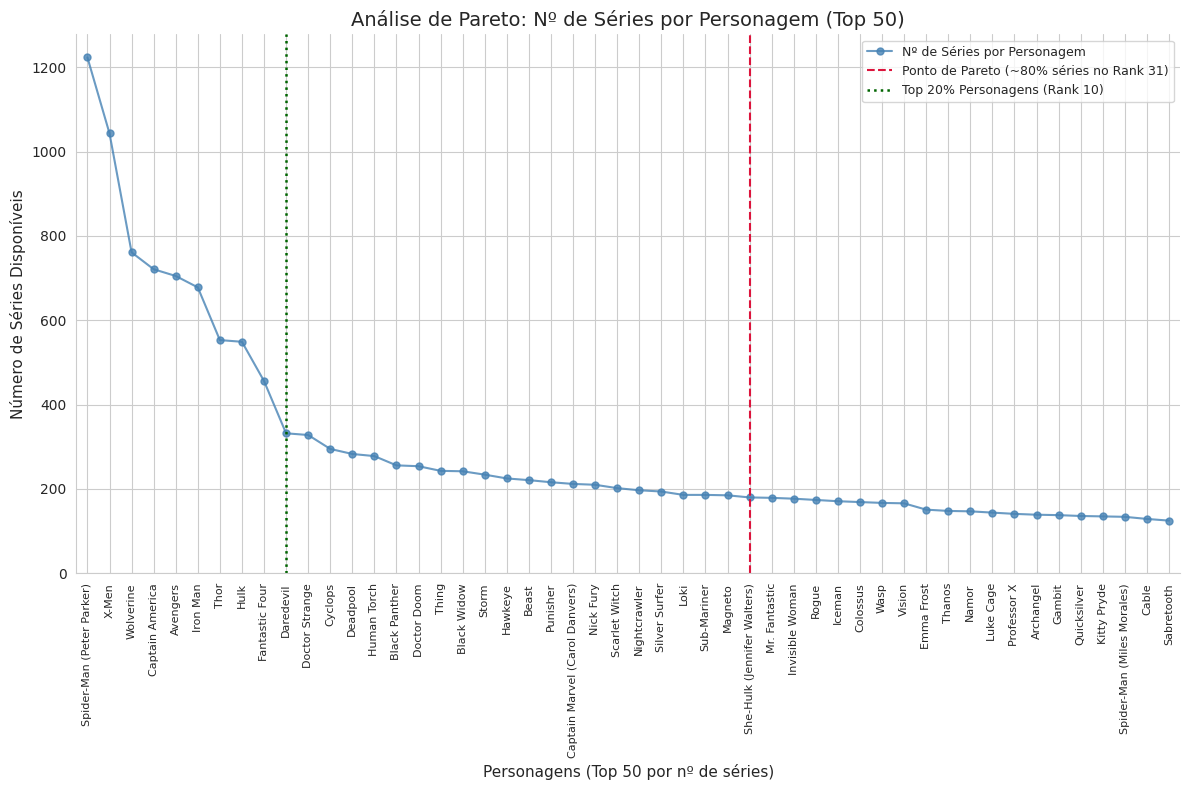

In [29]:
def principio_pareto_series():
    conn = sqlite3.connect(DB_NAME)
    df_principio_pareto = pd.read_sql('''
    WITH
      top50 AS (
        SELECT
          id,
          name,
          series_available
        FROM characters
        ORDER BY series_available DESC
        LIMIT 50
      ),
      sum50 AS (
        SELECT SUM(series_available) AS total_series
        FROM top50
      )
    SELECT
      ROW_NUMBER() OVER (ORDER BY t.series_available DESC) AS rank,
      t.id,
      t.name,
      t.series_available,
      s.total_series AS total_series_top50,
      ROUND(
        t.series_available * 100.0 / s.total_series
      , 2) AS pct_individual,
      ROUND(
        SUM(t.series_available) OVER (
          ORDER BY t.series_available DESC
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) * 100.0 / s.total_series
      , 2) AS pct_acumulada
    FROM top50 AS t
    CROSS JOIN sum50 AS s
    ORDER BY rank;
    ''', conn)
    conn.close()

    print("\n--- Amostra dos Dados da Análise de Pareto (Top 10) ---")
    print(df_principio_pareto[['rank', 'name', 'series_available', 'pct_acumulada']].head(10).to_string(index=False))
    return df_principio_pareto

# Carrega o DataFrame
# Se df_principio_pareto estiver vazio aqui, o código subsequente provavelmente falhará.
df_principio_pareto = principio_pareto_series()

# --- Gráfico de Pareto
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

line_color = 'steelblue'
ax.plot(df_principio_pareto['rank'].values,
        df_principio_pareto['series_available'],
        marker='o', markersize=5, linestyle='-', linewidth=1.5,
        color=line_color, alpha=0.8, label='Nº de Séries por Personagem')

# Ponto de 80% acumulado
pareto_highlight_color_80 = 'crimson'
pareto_point_80 = df_principio_pareto[df_principio_pareto['pct_acumulada'] >= 80].iloc[0]
rank_pareto_80 = pareto_point_80['rank']

ax.axvline(rank_pareto_80, color=pareto_highlight_color_80, linestyle='--', linewidth=1.5,
           label=f"Ponto de Pareto (~80% séries no Rank {int(rank_pareto_80)})")

# Linha para os 20% dos personagens (Top 10 de 50)
rank_20_percent_personagens = 10
color_20_percent_line = 'darkgreen'
ax.axvline(rank_20_percent_personagens,
           color=color_20_percent_line,
           linestyle=':',
           linewidth=1.8,
           label=f"Top 20% Personagens (Rank {rank_20_percent_personagens})")

# Ajustes dos eixos e títulos
ax.set_xlabel('Personagens (Top 50 por nº de séries)', fontsize=11)
ax.set_ylabel('Número de Séries Disponíveis', fontsize=11)
ax.set_title('Análise de Pareto: Nº de Séries por Personagem (Top 50)', fontsize=14)

ax.set_xticks(df_principio_pareto['rank'].values)
ax.set_xticklabels(df_principio_pareto['name'], rotation=90, ha='center', fontsize=8)

ax.legend(loc='upper right', fontsize=9)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=df_principio_pareto['rank'].max() + 0.5)

sns.despine(fig=fig, ax=ax)
plt.tight_layout()
plt.show()

<ipython-input-37-7ef7cc090acc>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='num_comics', y='title', data=df_top_series, palette='viridis')


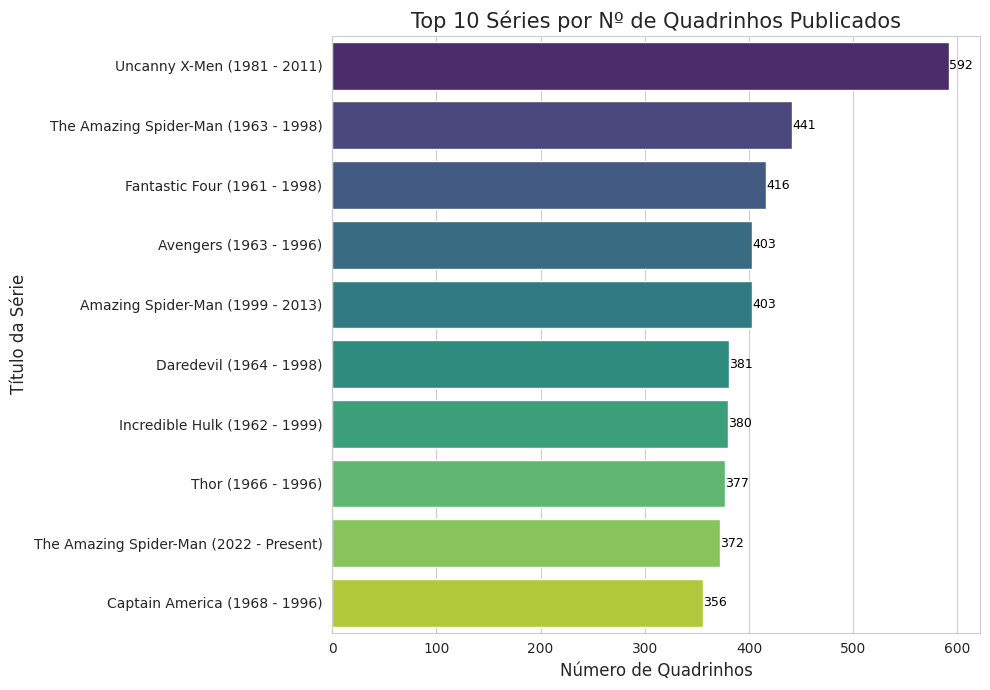

In [37]:
def get_top_series_by_comics(limit=10):
    """Busca as top N séries em andamento por número de quadrinhos."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f'''
            SELECT s.title, COUNT(c.id) AS num_comics
            FROM comics c
            JOIN series s ON c.id_series = s.id
            GROUP BY s.title
            ORDER BY num_comics DESC
            LIMIT {limit}
        '''
        df = pd.read_sql_query(query, conn)
    return df

# --- Análise: Top Séries por Número de Quadrinhos ---
df_top_series = get_top_series_by_comics()


# Plotar gráfico
plt.figure(figsize=(10, 7))
# Usar uma paleta de cores e o barplot do seaborn
barplot = sns.barplot(x='num_comics', y='title', data=df_top_series, palette='viridis')

# Adicionar rótulos de dados às barras
for index, value in enumerate(df_top_series['num_comics']):
    barplot.text(value + 0.3,  # Posição x (valor + pequeno deslocamento para não sobrepor)
                  index,      # Posição y (índice da barra)
                  str(value), # Texto do rótulo
                  color='black', va='center', ha='left', fontsize=9)

plt.title('Top 10 Séries por Nº de Quadrinhos Publicados', fontsize=15)
plt.xlabel('Número de Quadrinhos', fontsize=12)
plt.ylabel('Título da Série', fontsize=12)
plt.tight_layout() # Ajusta o layout
plt.show()

<ipython-input-42-7ef7cc090acc>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='num_comics', y='title', data=df_top_series, palette='viridis')


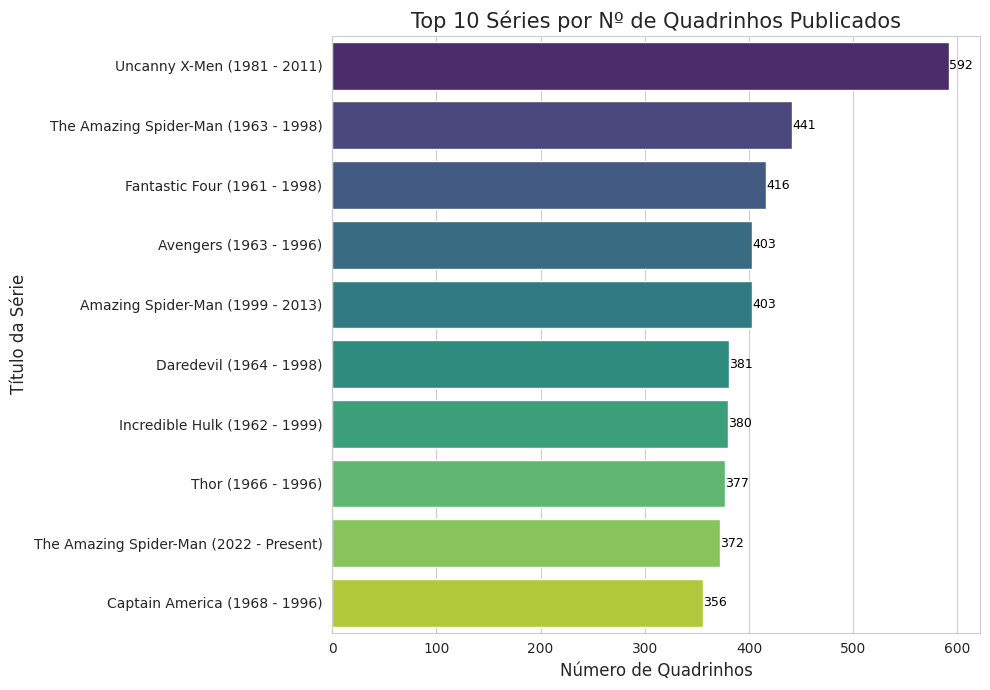

In [42]:
def get_top_series_by_comics(limit=10):
    """Busca as top N séries em andamento por número de quadrinhos."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f'''
            SELECT s.title, COUNT(c.id) AS num_comics
            FROM comics c
            JOIN series s ON c.id_series = s.id
            GROUP BY s.title
            ORDER BY num_comics DESC
            LIMIT {limit}
        '''
        df = pd.read_sql_query(query, conn)
    return df

# --- Análise: Top Séries por Número de Quadrinhos ---
df_top_series = get_top_series_by_comics()


# Plotar gráfico
plt.figure(figsize=(10, 7))
# Usar uma paleta de cores e o barplot do seaborn
barplot = sns.barplot(x='num_comics', y='title', data=df_top_series, palette='viridis')

# Adicionar rótulos de dados às barras
for index, value in enumerate(df_top_series['num_comics']):
    barplot.text(value + 0.3,  # Posição x (valor + pequeno deslocamento para não sobrepor)
                  index,      # Posição y (índice da barra)
                  str(value), # Texto do rótulo
                  color='black', va='center', ha='left', fontsize=9)

plt.title('Top 10 Séries por Nº de Quadrinhos Publicados', fontsize=15)
plt.xlabel('Número de Quadrinhos', fontsize=12)
plt.ylabel('Título da Série', fontsize=12)
plt.tight_layout() # Ajusta o layout
plt.show()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


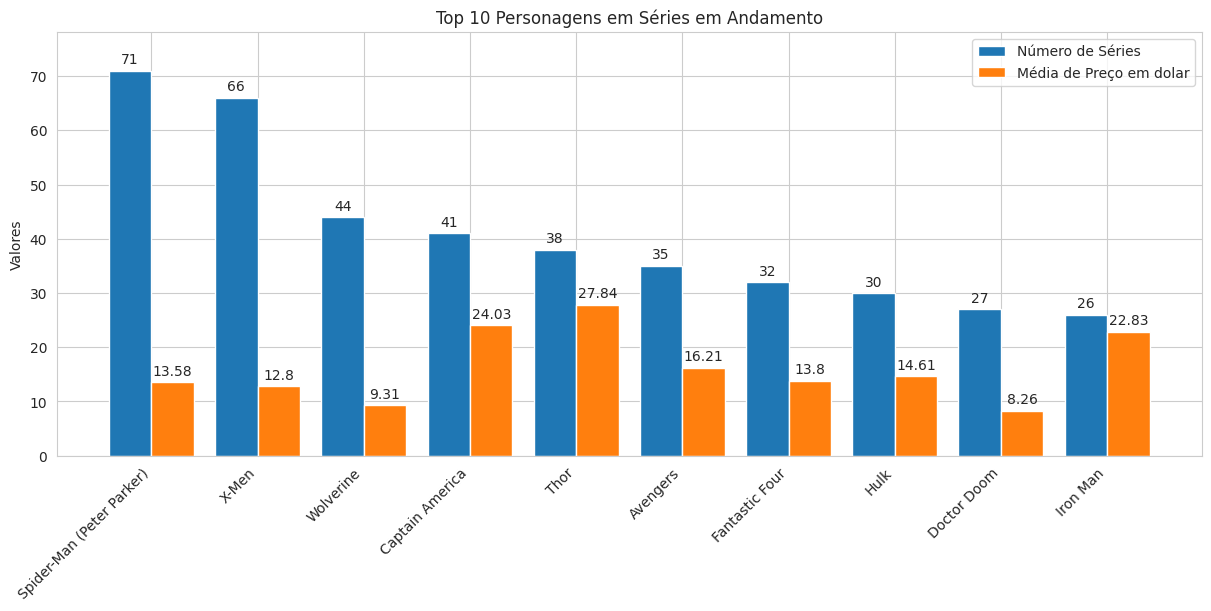

In [34]:
#personagens que mais aparecem em series em andamento e a média de preço por serie desses personagens
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

df_personagens_mais_em_series = pd.DataFrame(show_table_sample())

# Preparando o gráfico
characters = df_personagens_mais_em_series['nome_personagem'].tolist()
attributes = ['num_series', 'media_preco']
labels = ['Número de Séries', 'Média de Preço em dolar']

x = np.arange(len(characters))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for attr, label in zip(attributes, labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, df_personagens_mais_em_series[attr], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Personagens em Séries em Andamento')
ax.set_xticks(x + width/2, characters, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, max(df_personagens_mais_em_series['num_series'].max(), df_personagens_mais_em_series['media_preco'].max()) * 1.1)

plt.show()


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


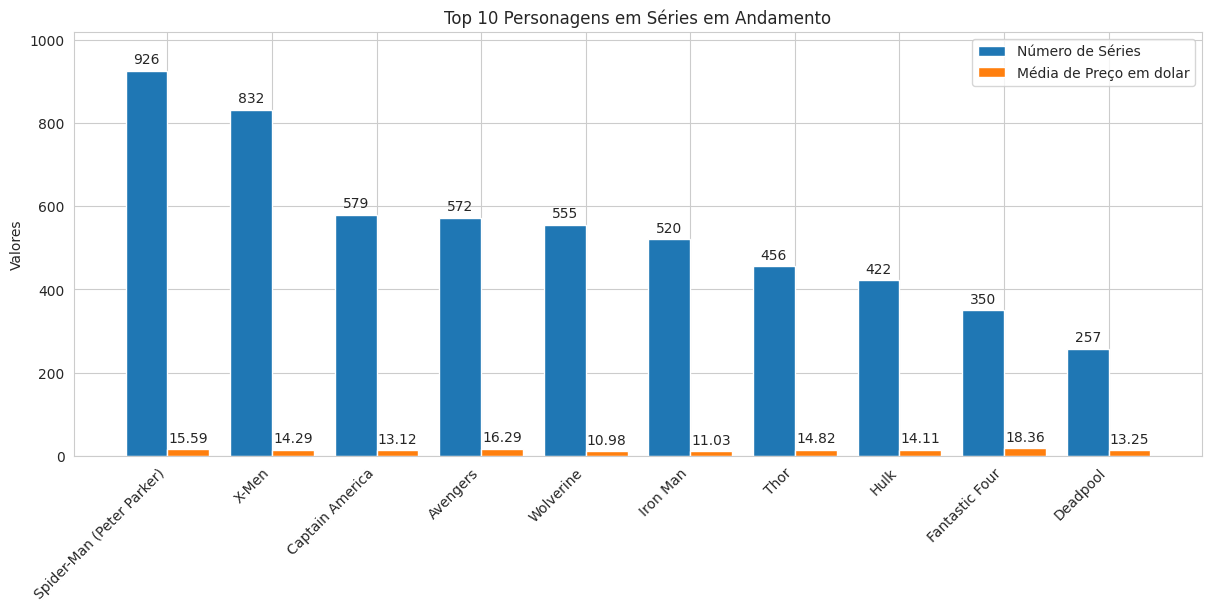

In [36]:
#personagens que mais aparecem em series e a média de preço por serie desses personagens
def show_table_sample():
    conn = sqlite3.connect('marvel_characters_teste.db')
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

df_personagens_mais_em_series = pd.DataFrame(show_table_sample())

# Preparando o gráfico
characters = df_personagens_mais_em_series['nome_personagem'].tolist()
attributes = ['num_series', 'media_preco']
labels = ['Número de Séries', 'Média de Preço em dolar']

x = np.arange(len(characters))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for attr, label in zip(attributes, labels):
    offset = width * multiplier
    rects = ax.bar(x + offset, df_personagens_mais_em_series[attr], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Personagens em Séries em Andamento')
ax.set_xticks(x + width/2, characters, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, max(df_personagens_mais_em_series['num_series'].max(), df_personagens_mais_em_series['media_preco'].max()) * 1.1)

plt.show()


Estatísticas descritivas do número de séries associadas por evento:
count    68.000000
mean     14.088235
std      14.602939
min       1.000000
25%       4.000000
50%       9.500000
75%      17.000000
max      85.000000


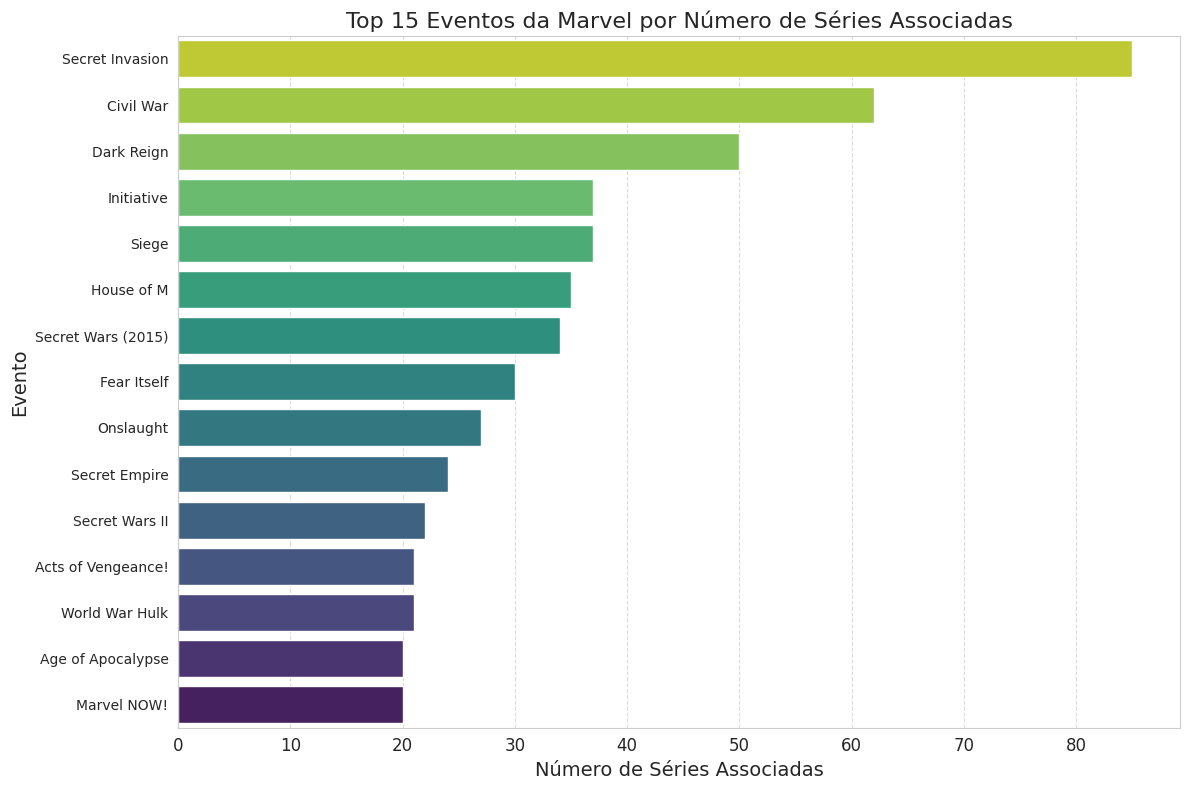

In [32]:
def fetch_all_events_by_series_count_sorted():
    """
    Busca TODOS os eventos e o número de séries de quadrinhos associadas,
    ordenados pelo número de séries.
    """
    conn = sqlite3.connect(DB_NAME)
    query = """
    SELECT
        e.title AS event_title,
        COUNT(DISTINCT es.id_serie) AS num_series_associated
    FROM
        events e
    JOIN
        events_series es ON e.id = es.id_event
    WHERE e.title IS NOT NULL AND e.title != '' -- Evitar eventos sem título
    GROUP BY
        e.id, e.title  -- Agrupar por ID do evento para contagem correta
    ORDER BY
        num_series_associated DESC;
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

df_all_events_series = fetch_all_events_by_series_count_sorted()

print("\nEstatísticas descritivas do número de séries associadas por evento:")
print(df_all_events_series['num_series_associated'].describe().to_string())

# Para alterar a quantidade de linhas na tabela altere o valor top_n
top_n = 15
df_top_n_events_series = df_all_events_series.head(top_n)

# Gráfico de Barras Horizontais: Top N Eventos por Número de Séries Associadas
plt.figure(figsize=(12, 8))
# Aplicando a correção para o FutureWarning do Seaborn ao usar palette
barplot = sns.barplot(
    data=df_top_n_events_series,
    x='num_series_associated',
    y='event_title',
    palette='viridis_r', # Usando uma paleta invertida (maior valor com cor mais "forte")
    hue='event_title',   # Atribuir 'y' a 'hue' para aplicar a paleta por barra
    dodge=False,         # Evitar que as barras se "esquivem"
    legend=False         # Legenda redundante neste caso
)

# Adicionar rótulos de dados nas barras para clareza
for index, row in df_top_n_events_series.iterrows():
    value = row['num_series_associated']

    y_pos = df_top_n_events_series['event_title'].tolist().index(row['event_title'])

plt.title(f'Top {top_n} Eventos da Marvel por Número de Séries Associadas', fontsize=16)
plt.xlabel('Número de Séries Associadas', fontsize=14)
plt.ylabel('Evento', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

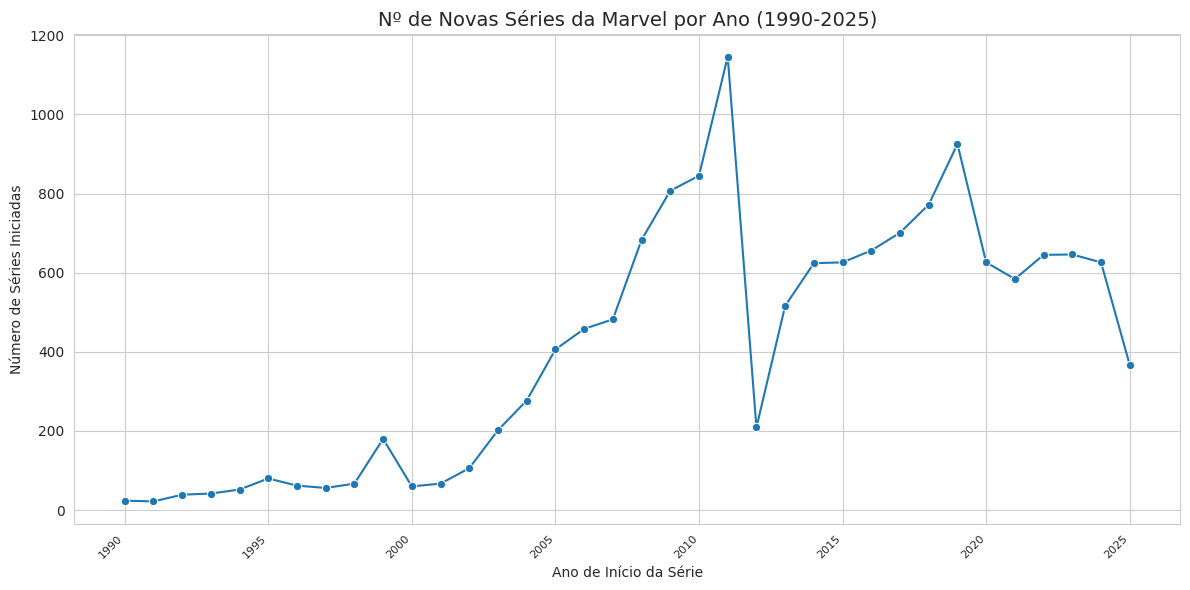

In [33]:
def fetch_series_started_by_year_filtered():
    """Busca o número de séries iniciadas por ano, dentro de um intervalo."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f"""
            SELECT
                start_year,
                COUNT(DISTINCT id) AS num_series_started
            FROM
                series
            WHERE
                start_year IS NOT NULL
                AND start_year >= 1990
                AND start_year <= 2025
            GROUP BY
                start_year
            ORDER BY
                start_year ASC;
        """
        df = pd.read_sql_query(query, conn)
    return df

df_series_by_year_filtered = fetch_series_started_by_year_filtered()


plt.figure(figsize=(12, 6)) # Tamanho razoável para o gráfico
sns.set_style("whitegrid") # Estilo limpo

sns.lineplot(
    data=df_series_by_year_filtered,
    x='start_year',
    y='num_series_started',
    marker='o',       # Adiciona marcadores para destacar os anos
    linewidth=1.5     # Espessura da linha
)

plt.title(f'Nº de Novas Séries da Marvel por Ano (1990-2025)', fontsize=14)
plt.xlabel('Ano de Início da Série', fontsize=10)
plt.ylabel('Número de Séries Iniciadas', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8) # Rotação para melhor leitura dos anos
plt.yticks(fontsize=10)


plt.tight_layout() # Ajusta o layout para não cortar os rótulos
plt.show()


O Marvel NOW! foi um grande relançamento da linha editorial da Marvel Comics que começou no final de 2012, após a conclusão do evento "Avengers vs. X-Men". A maior parte das novas séries e novas equipes criativas associadas a essa iniciativa tiveram seus lançamentos e consolidação ao longo de 2013.

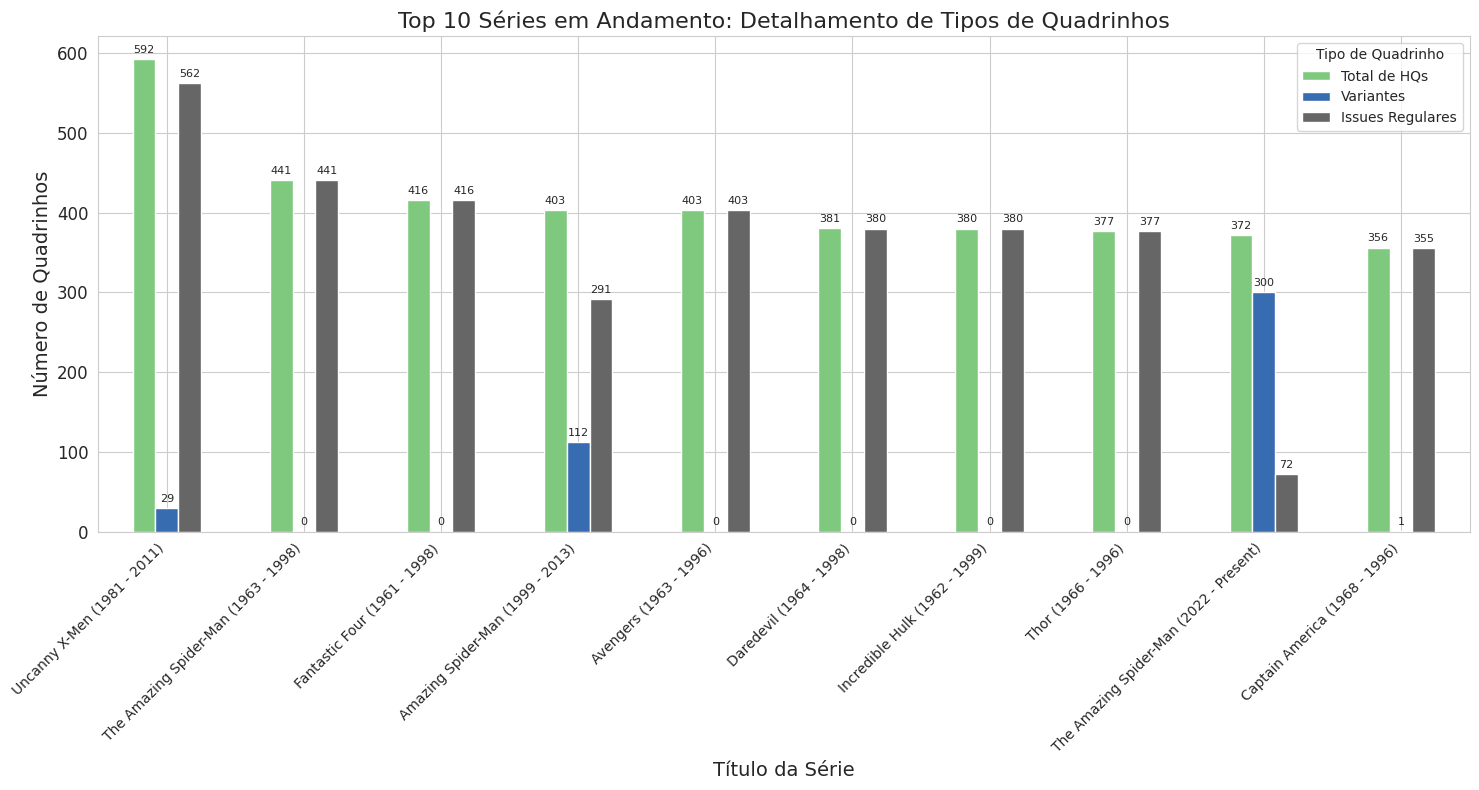

In [74]:
def get_top_series_comic_types_count(limit=10):
    """
    Busca as top N séries em andamento e conta o número total de quadrinhos,
    o número de variantes e o número de issues/edições regulares.
    """
    with sqlite3.connect(DB_NAME) as conn:
        query = f'''
            SELECT
                s.title,
                COUNT(c.id) AS total_comics,
                SUM(CASE
                        WHEN c.variant_description IS NOT NULL AND c.variant_description != ''
                        THEN 1
                        ELSE 0
                    END) AS num_variants,
                SUM(CASE
                        WHEN (c.variant_description IS NULL OR c.variant_description = '')
                             AND c.issue_number IS NOT NULL AND c.issue_number > 0
                        THEN 1
                        ELSE 0
                    END) AS num_regular_issues
            FROM
                series s
            JOIN
                comics c ON s.id = c.id_series
            GROUP BY
                s.id, s.title
            ORDER BY
                total_comics DESC
            LIMIT {limit};
        '''
        df = pd.read_sql_query(query, conn)
    return df

# --- Análise: Top Séries por Tipos de Quadrinhos ---
df_top_series_detailed = get_top_series_comic_types_count()

# Preparar dados para o gráfico
df_plot = df_top_series_detailed.set_index('title')[['total_comics', 'num_variants', 'num_regular_issues']]
df_plot.columns = ['Total de HQs', 'Variantes', 'Issues Regulares'] # Nomes para a legenda

# Usar um estilo Seaborn para uma estética geral melhor:
# 'sns.set_style("whitegrid")' aplica um tema visual da biblioteca Seaborn,
# que geralmente deixa os gráficos com uma aparência mais limpa e profissional,
# adicionando uma grade de fundo branca.
sns.set_style("whitegrid")

# Plotar o gráfico de barras verticais:
# 'df_plot.plot(...)' é um método do Pandas que usa o Matplotlib por baixo dos panos
# para criar gráficos rapidamente a partir de um DataFrame.
ax = df_plot.plot(
    kind='bar',       # Especifica o tipo de gráfico: 'bar' para barras verticais.
                      # Se fosse 'barh', seriam barras horizontais.
    figsize=(15, 8),  # Define o tamanho da figura do gráfico em polegadas (largura, altura).
                      # Ajuste conforme necessário para seus dados e tela.
    colormap='Accent' # Define um esquema de cores para as barras. O Pandas/Matplotlib
                      # aplicará cores diferentes do colormap 'Accent' para cada coluna
                      # em 'df_plot' (Total de HQs, Variantes, Issues Regulares).
                      # Você pode experimentar outros como 'viridis', 'Pastel1', 'Set2', 'tab10'.
)
# O 'ax' retornado é um objeto "Axes" do Matplotlib, que representa a área de plotagem
# e permite customizações detalhadas.

# Definindo Títulos e Rótulos dos Eixos:
plt.title('Top 10 Séries em Andamento: Detalhamento de Tipos de Quadrinhos', fontsize=16)
plt.xlabel('Título da Série', fontsize=14) # Rótulo do eixo X
plt.ylabel('Número de Quadrinhos', fontsize=14) # Rótulo do eixo Y

# Customizando os Ticks (Marcadores) do Eixo X:
# Como os títulos das séries (agora no eixo X) podem ser longos, rotacionamos.
plt.xticks(rotation=45,    # Rotaciona os rótulos em 45 graus.
           ha='right',     # Alinha os rótulos rotacionados à direita do tick.
           fontsize=10)    # Define o tamanho da fonte.
plt.yticks(fontsize=12)     # Define o tamanho da fonte para os ticks do eixo Y.

# Adicionar Rótulos de Dados (labels) em cima de cada barra:
# 'ax.containers' é uma lista dos grupos de barras no gráfico.
# (neste caso, um grupo para 'Total de HQs', um para 'Variantes', etc., embora aqui
# o pandas.plot agrupe por série e cada série tenha 3 barras de tipos diferentes)
# O loop itera sobre cada "container" de barras (cada conjunto de barras para um tipo).
for container in ax.containers:
    # 'ax.bar_label(...)' adiciona automaticamente o valor numérico de cada barra.
    ax.bar_label(container,      # O container de barras onde os rótulos serão adicionados.
                 label_type='edge', # Posiciona o rótulo na borda externa da barra.
                 fontsize=8,        # Tamanho da fonte do rótulo.
                 padding=3)         # Pequeno espaçamento entre a barra e o rótulo.

# Adicionando a Legenda:
# 'ax.legend(...)' mostra a legenda para identificar as cores das barras.
ax.legend(title='Tipo de Quadrinho', # Título da caixa de legenda.
          fontsize=10)          # Tamanho da fonte da legenda.

# Ajuste Final e Exibição:
# 'plt.tight_layout()' ajusta automaticamente os parâmetros do gráfico (como margens)
# para que tudo (títulos, rótulos, legenda) caiba bem na figura sem sobreposição.
plt.tight_layout()
# 'plt.show()' efetivamente exibe o gráfico gerado.
plt.show()
